# ADCG noise impact investigation

* In this notebook we try to asses the impact of noise on the performance of ADCG in a 1D deconvolution task.

## Imports

In [3]:
import autograd.numpy as np
import autograd
import scipy.optimize
import pylab
from time import time
import seaborn as sns
pylab.ion()

## Style

In [4]:
sns.set_style("darkgrid")
pylab.rcParams["lines.linestyle"] = ':'
pylab.rcParams["lines.linewidth"] = 5
pylab.rcParams["figure.figsize"] = (14, 5)

## Setup

In [5]:
# Global variables
evaluation_points = np.linspace(0, 1, 50)
σ = 0.1

# Gaussian
def ψ(θ):
    return np.exp(-((evaluation_points - θ) / σ) ** 2)

# Weighted shifted gaussian functions
def Ψ(ws, θs):
    return np.sum(np.array([w*ψ(θ) for (w, θ) in zip(ws, θs)]), 0)

# Loss function
def l(ws, θs):
    return ((Ψ(ws, θs) - y) ** 2).sum()

# Generate ground truth θs and weights ws
np.random.seed(69)
num_true_θs = np.random.randint(2, 5)
noise_level = 0.2
true_θs = np.random.rand(num_true_θs)
true_weights = np.random.rand(num_true_θs) + 1

# Grid
grid_points = np.linspace(0, 1, 30)
grid_psi = np.stack([ψ(θ) for θ in grid_points])

def lmo(v):
    scores = grid_psi @ v
    return grid_points[scores.argmin()]

## ADCG

In [6]:
# ADCG second step "coordination optimization solving attempt"
def coordinate_descent(θs, target, iters=35, min_drop=1e-5, ):
    def min_ws():
        return scipy.optimize.nnls(np.stack([ψ(θ) for θ in θs]).T, y)[0]
    def min_θs():
        res = scipy.optimize.minimize(
                autograd.value_and_grad(lambda θs: l(ws, θs)),
                                        θs,
                                        jac=True,
                                        method='L-BFGS-B',
                                        bounds=[(0.0, 1.0)]*len(θs))
        return res["x"], res["fun"]
    
    old_f_val = np.inf
    for iter in range(iters):
        ws = min_ws()
        θs, f_val = min_θs()
        # check if loss is stationary
        if old_f_val - f_val < min_drop:
            break
        old_f_val = f_val
    return ws, θs

In [7]:
# Define ADCG
def ADCG(local_update, max_iters, target):
    θs = np.zeros(0)
    ws = np.zeros(0)
    output = np.zeros(len(evaluation_points))
    history = list()
    for iter in range(max_iters):
        residual = output - target
        loss = (residual**2).sum()
        #print(iter, loss)
        history.append((loss, θs, ws))
        θ = lmo(residual)
        ws, θs = local_update(np.append(θs, θ), target=target)
        output = Ψ(ws, θs)
    return history

In [8]:
# Define heuristic for selecting the number of true sources
def select_k(history):
    drop = np.array([history[i][0] - history[i+1][0]
                    for i in range(len(history) - 1)])
    k_hat = np.argmax(drop<0.1)
    return history[k_hat]

## CGMM

In [34]:
# Implement CGM-M
def min_ws(θs, target):
    return scipy.optimize.nnls(np.stack([ψ(θ) for θ in θs]).T, target)[0]

def CGMM(max_iters, target):
    θs = np.zeros(0)
    ws = np.zeros(0)
    output = np.zeros(len(evaluation_points))
    history = list()
    for iter in range(max_iters):
        residual = output - target
        loss = (residual**2).sum()
        #print(iter, loss)
        history.append((loss, θs, ws))
        # Compute new support
        θ = lmo(residual)
        θs = np.append(θs, θ)
        # Compute weights
        ws = min_ws(θs, target=target)
        output = Ψ(ws, θs)
    return history

## Noise impact on number of recovered bumps

In [39]:
## Noise levels
noise_levels = np.arange(0.05, 1.0, 0.05)
n_recovery_cgmm = list()
n_recovery_adcg = list()
np.random.seed(69)
for noise_level in noise_levels: 
    y = (Ψ(true_weights, true_θs) 
         + noise_level * np.random.randn(len(evaluation_points)))
    res_adcg = select_k(ADCG(coordinate_descent, 10, target=y))
    res_cgmm = select_k(CGMM(10, target=y)[1:])
    n_recovery_adcg.append(len(res_adcg[1]))
    n_recovery_cgmm.append(len(res_cgmm[1]))

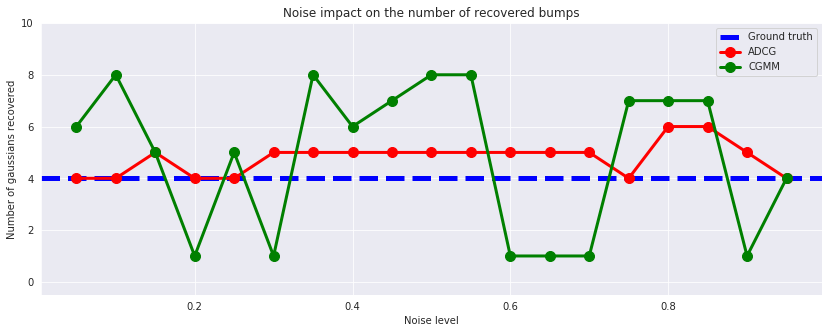

In [41]:
pylab.figure(figsize=(14, 5))
pylab.title("Noise impact on the number of recovered bumps")
pylab.axhline(4, label="Ground truth", linestyle="--", color="blue")
pylab.plot(noise_levels, n_recovery_adcg, marker="o", linestyle="-", markersize=10, linewidth=3, color="red", label="ADCG")
pylab.plot(noise_levels, n_recovery_cgmm, marker="o", linestyle="-", markersize=10, linewidth=3, color="green", label="CGMM")
pylab.ylim(-0.5, 10)
pylab.xlabel("Noise level")
pylab.ylabel("Number of gaussians recovered")
pylab.legend(frameon=True)

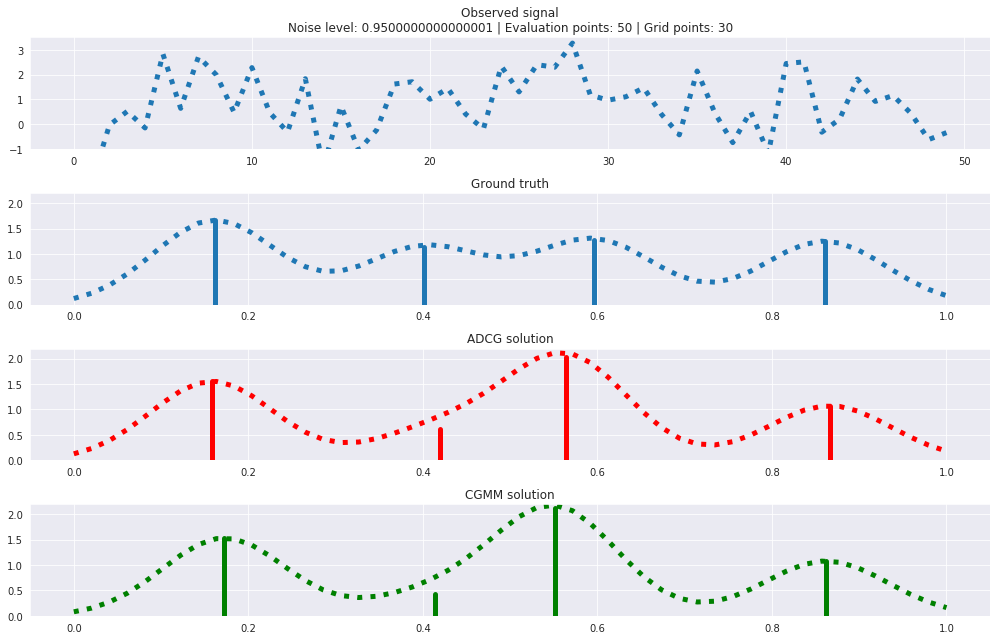

In [48]:
figure, axes = pylab.subplots(nrows=4, ncols=1, figsize=(14, 9))
for ax in axes[1:]:
    ax.set_ylim(bottom=0., top=2.2)

axes[0].set_title("Observed signal\n"
                  f"Noise level: {noise_level} | "
                  f"Evaluation points: {len(evaluation_points)} | "
                  f"Grid points: {len(grid_points)}")
axes[0].set_ylim(bottom=-1., top=3.5)
axes[0].plot(y)
axes[1].set_title("Ground truth")
axes[1].plot(evaluation_points, Ψ(true_weights, true_θs))
for i, θ in enumerate(true_θs):
    axes[1].axvline(x=θ, ymax=true_weights[i] / axes[1].get_ylim()[1],
                    linestyle="-")
axes[2].set_title("ADCG solution")
axes[2].plot(evaluation_points, Ψ(res_adcg[2], res_adcg[1]), c="red")
for i, θ in enumerate(res_adcg[1]):
    axes[2].axvline(x=θ, ymax=res_adcg[2][i] / axes[2].get_ylim()[1],
                    linestyle="-", color="red")
axes[3].set_title("CGMM solution")
axes[3].plot(evaluation_points, Ψ(res_cgmm[2], res_cgmm[1]), c="green")
for i, θ in enumerate(res_cgmm[1]):
    axes[3].axvline(x=θ, ymax=res_cgmm[2][i] / axes[3].get_ylim()[1],
                    linestyle="-", color="green")
pylab.tight_layout();